<center><font size = "10"> Week 8 - Synapses <center>
<center><font size = "8">Home work 

<font size = "3">Please, write your group number and the names and surnames of the group members here
<br>Group number: 8
<br>Group member1: Chiara Maria Matti
<br>Group member2: Elena Grazia Gado
<br>Group member3: Eliser Josan Romero
    
__IMPORTANT:__<font size = "3"> assignements to be delivered by next Monday before 23:59.

In [1]:
# For this exercises just compile channel and synaptic mechanisms at the begining and you won't need to do this again.
!nrnivmodl

/home/W8
Mod files: "./NaTs2_t.mod" "./SK_E2.mod" "./SKv3_1.mod" "./SimpleAMPA_NMDA.mod" "./TsodyksMarkram_AMPA_NMDA.mod" "./vecevent.mod"

 -> Compiling mod_func.cpp
 => LINKING shared library ./libnrnmech.so
Successfully created x86_64/special


In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import neuron
from neuron import h

sns.set_style('darkgrid')
sns.set(font_scale=1.1)

%matplotlib inline

--No graphics will be displayed.


# <font color= 'red'>Ex 1:</font> Plot the dependence of the NMDA conductance on the Mg2+ concentration.

<font size='3'>Create a single compartmental soma neuron to host the synpase modeled in SimpleAMPA_NMDA.mod file. Using the stimulation pattern and the values for the synaptic conductances used in tutorial 01, plot the NMDA conductance at different mM [Mg2+] values. Select appropiate values to explore the dynamics. 
    
<font size='3'> What happens to the NMDA conducatance in relation to Mg2+? What is the functional purpose of this behaviour?
    
<font size='3'><font color= 'red'>[0.5 pts]</font>

In [3]:
# Load external files & initialize
h.load_file("stdrun.hoc")
h.stdinit()

0.0

In [4]:
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert("pas")

__nrnsec_0x55e23205ea20

In [5]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

In [6]:
synapse = h.SimpleAMPA_NMDA(soma(0.5))

In [7]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0  # In units of [nS] due to the gmax scaling factor in our .mod file

In [8]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)

Vector[4]

In [9]:
def dual_exp(t, tau_r, tau_d, t_start):
    """Compute the dual exponential time course using the closed form expression."""
    t = np.array(t)
    time_to_peak = (tau_r * tau_d) / (tau_d - tau_r) * np.log(tau_d / tau_r)
    factor = -np.exp(-time_to_peak / tau_r) + np.exp(-time_to_peak / tau_d)
    f_dual_exp = lambda t: (np.exp(-t / tau_d) - np.exp(-t / tau_r)) / factor
    
    dual_exp = np.zeros_like(t)
    dual_exp[t >= t_start] = f_dual_exp(t[t >= t_start] - t_start)
    
    return dual_exp

In [10]:
def compare_exp(t, g, tau_r, tau_d, t_start, t_end):
    time = np.array(t)
    g_syn = np.array(g)

    firstspike = np.logical_and(time > t_start, time < t_end)
    plt.figure(figsize=(20, 10))
    plt.plot(time[firstspike], g_syn[firstspike], label="conductance")
    plt.plot(
        time[firstspike],
        0.001 * connection.weight[0] * dual_exp(
            time[firstspike], tau_r, tau_d, t_start=100.0 + connection.delay
        ),
        "r--",
        lw=2,
        label="math. expr.",
    )
    plt.legend();

In [11]:
DURATION = 1100
# synapse.gmax_NMDA = 0.001  # uS
# synapse.mg = 0.2  # mM
# synapse.gmax_AMPA = 0  # uS
# h.finitialize(-70)
# h.continuerun(DURATION)

In [12]:
range_mg = np.arange(0.0, 2.0, 0.2)
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange','purple', 'pink']

In [13]:
range_mg

array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8])

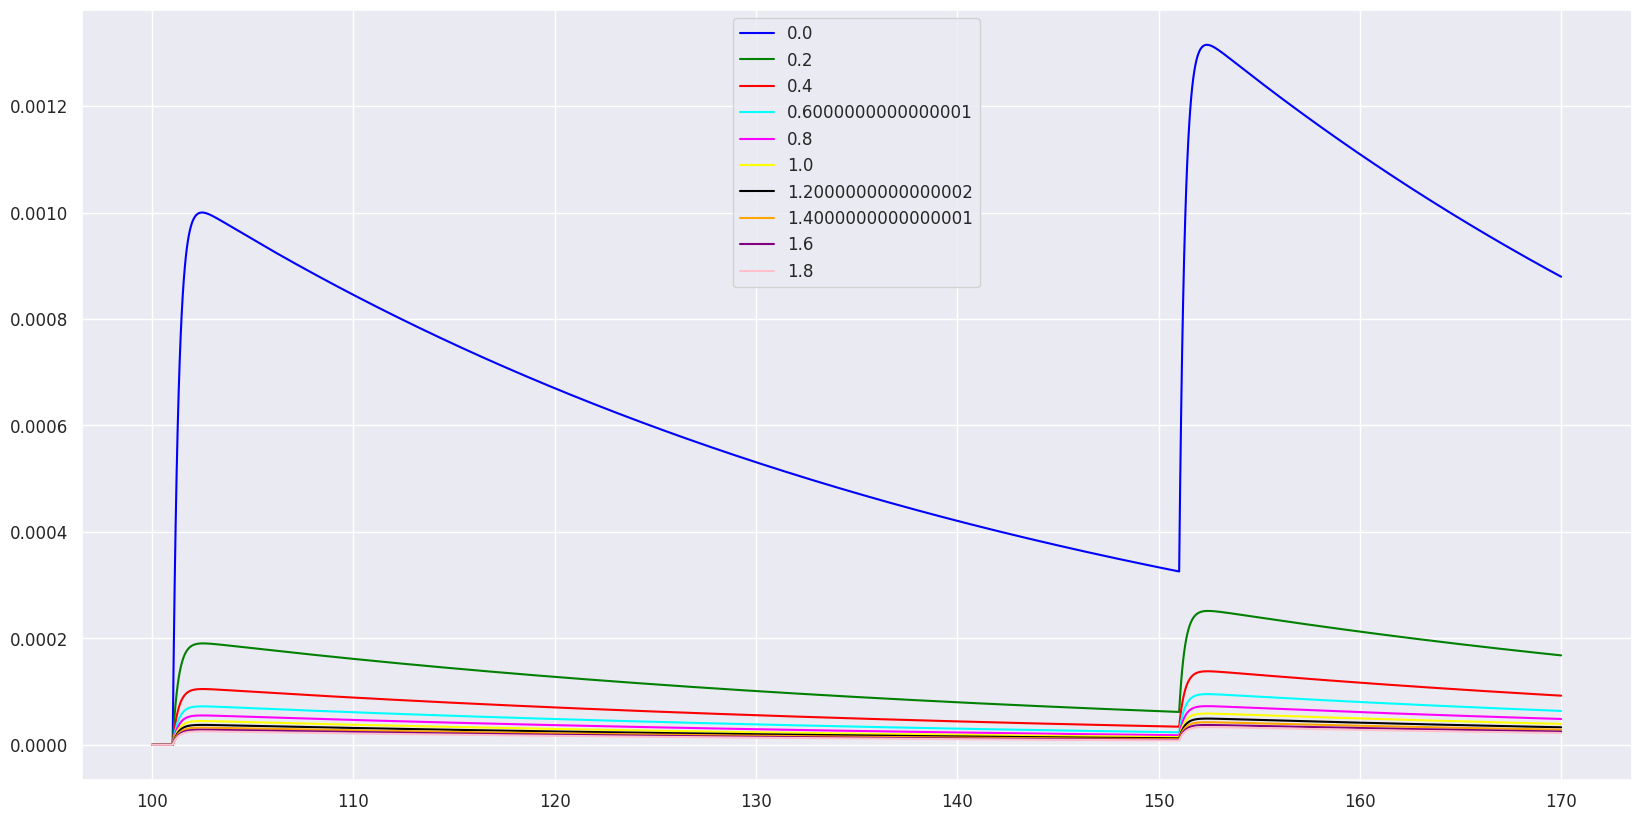

In [14]:
t_start = 100
t_end = 170

import numpy as np
import matplotlib.pyplot as plt

# Assuming you have defined `range_mg` and `colors` elsewhere in your code
# Assuming 'synapse' and 'soma' are previously defined in your code

DURATION = 1100
synapse.gmax_NMDA = 0.001  # uS
synapse.gmax_AMPA = 0  # uS


# Define time vector outside the loop
time = h.Vector()
time.record(neuron.h._ref_t)

g_syn = h.Vector()
g_syn.record(synapse._ref_g)


plt.figure(figsize=(20, 10))
for mgc, col in zip(range_mg, colors):
    
    #DURATION = 1100
    # synapse.gmax_NMDA = 0.001  # uS
    synapse.mg = mgc  # mM
    # synapse.gmax_AMPA = 0  # uS
    h.finitialize(-70)
    h.continuerun(DURATION)
    
    # print(time)
    
    
    # You had an issue here with 'i_syn' and 'v_soma', which were overwritten in each iteration.
    i_syn = h.Vector()
    i_syn.record(synapse._ref_i)
    
    v_soma = h.Vector()
    v_soma.record(soma(0.5)._ref_v)
    
    tau_r = synapse.tau_r_NMDA
    tau_d = synapse.tau_d_NMDA
    
    t= np.array(time)
    gs = np.array(g_syn)
    
    
    firstspike = np.logical_and(t > t_start, t < t_end)
    
    

    plt.plot(t[firstspike], gs[firstspike], label=str(mgc), color=col)
    # plt.plot(
    #     time[firstspike],
    #     0.001 * connection.weight[0] * dual_exp(
    #         time[firstspike], tau_r, tau_d, t_start=100.0 + connection.delay
    #     ),
    #     # "r--",
    #     lw=2,
    #     label=str(mgc),  # Use str() to convert mgc to a string for the legend
    #     color=col  # Use 'color' parameter to set the color
    # )

plt.legend()
plt.show()


We can observe how the presence of Mg2+ ions leads to the NMDA conductance to decrease to 0. This is because the NMDARs present a voltage-dependent magnesium block. Hence, Mg2+ ions inside the cell bind to the receptors and keep the channels close. The functional purpose of the magnesium block is to ensure that NMDA channels primarily open when the postsynaptic membrane is already depolarized. The depolarization occurs as a result of strong synaptic activity or coincident firing of presynaptic and postsynaptic neurons, which reduces the Mg^2+ block. Under these conditions, the NMDA receptors become unblocked, allowing the entry of calcium ions (Ca^2+) into the postsynaptic neuron through the NMDAR channels.
The influx of calcium ions, specifically through NMDA receptors, is a crucial step in initiating intracellular signaling pathways that are associated with various forms of synaptic plasticity, including long-term potentiation (LTP). 

<span style="color:purple"> 
<font size='3'> 
    
## **Grading**: 
- [0.1 pt] for good coding and having the plot
- [0.2 pt] explaning NMDA conductance in relation to Mg2+
- [0.2 pt] explaning functional purpose

[/0.5 pt]    
</span>

# <font color= 'red'>Ex 2:</font>  Configure a pseudolinear synapse (E1)
    
<font size='3'> Create a single compartmental soma neuron, add to it passive properties, add to the center of the neuron a synapse with the mechanism modeled in TsodyksMarkram_AMPA_NMDA.mod file, inject a stimulation pattern and define the conductances for NMDA and AMPA receptors, as it was done in tutorial 02. 

<font size='3'>Play around with `U1`, `tau_rec` and `tau_facil` , and find the values that make the synapse _pseudolinear_, so that it first undergoes facilitation, and then a depression as the stimulus goes on for longer. 

<font size='3'> Plot the `R`, `Use` and conductance curves. Explain in your own words what `U1`, `tau_rec` and `tau_facil` represent.
    
<font size='3'>Plot comparison (bar plot) between the three parameters for each of the three synapse types(facilitating, depressing and pseudolinear). Explain the relationships between the parameter values and the properties of the synapse type they belong to.
    
 
    
<font size='3'><font color= 'red'>[1.5 pts]</font>

In [15]:
import neuron
from neuron import h
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# Load external files & initialize
neuron.h.load_file("stdrun.hoc")
neuron.h.stdinit()

0.0

In [16]:
# Define cell shape
soma = neuron.h.Section()
soma.L = 40
soma.diam = 40
soma.insert("pas")

__nrnsec_0x55e23205ea80

In [17]:
# Configure the passive biophysics
for sec in h.allsec():
    sec.Ra = 100
    sec.cm = 1

In [18]:
synapse = h.TsodyksMarkram_AMPA_NMDA(soma(0.5))

In [19]:
stimulator = h.VecStim()
spike_times = [100.0, 150.0, 200.0, 250.0, 300.0, 350.0, 400.0, 450.0, 950.0]
spikes_vector = h.Vector(spike_times)
stimulator.play(spikes_vector)

connection = h.NetCon(stimulator, synapse)
connection.weight[0] = 1.0  # In units of [nS] due to the gmax scaling factor in our .mod file

In [20]:
g_syn = h.Vector()
g_syn.record(synapse._ref_g)
i_syn = h.Vector()
i_syn.record(synapse._ref_i)
v_soma = h.Vector()
v_soma.record(soma(0.5)._ref_v)
time = h.Vector()
time.record(neuron.h._ref_t)
R_syn = h.Vector()
R_syn.record(synapse._ref_R)
Use_syn = h.Vector()
Use_syn.record(synapse._ref_Use)

Vector[33]

In [21]:
synapse.gmax_AMPA = 0.002  # uS
synapse.gmax_NMDA = (0.7 * 0.002)  # uS 0.7 is a biologically typical ratio of NMDA to AMPA conductance
synapse.mg = 1.0  # mM

In [22]:
synapse.U1 = 0.29  # Baseline release probability
synapse.tau_rec = 100  # ms - recovery from depression
synapse.tau_facil = 200  # ms - relaxation from facilitation

h.tstop = 1000.0  # ms
neuron.h.run()

0.0

(0.0, 1000.0, -70.0, -69.0)

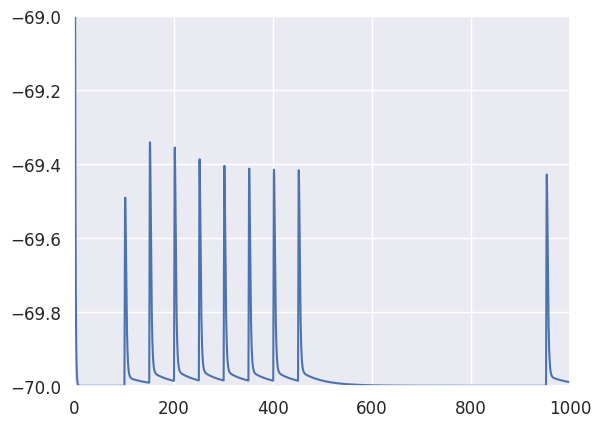

In [23]:
# plot how the post-synaptic EPSPs look like 
plt.figure()
plt.plot(time, v_soma)
plt.axis([0, 1000, -70, -69.0])

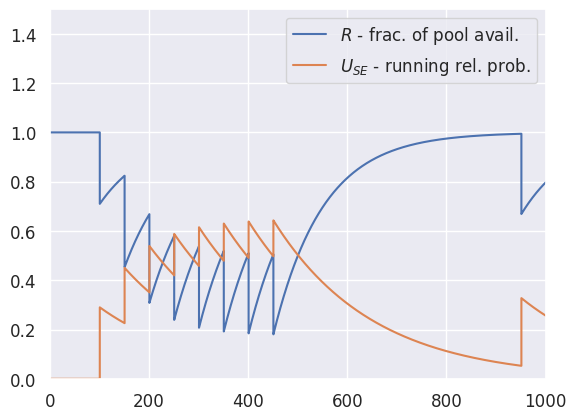

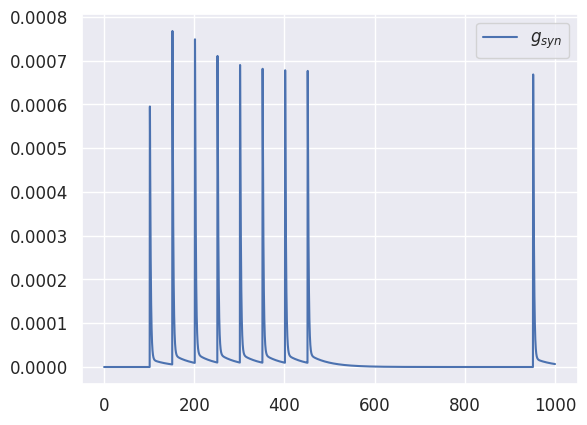

In [24]:
plt.figure()
plt.plot(time, R_syn, label="$R$ - frac. of pool avail.")
plt.plot(time, Use_syn, label="$U_{SE}$ - running rel. prob.")
plt.legend()
plt.axis([0, 1000, 0, 1.5])

plt.figure()
plt.plot(time, g_syn, label="$g_{syn}$")
plt.legend()

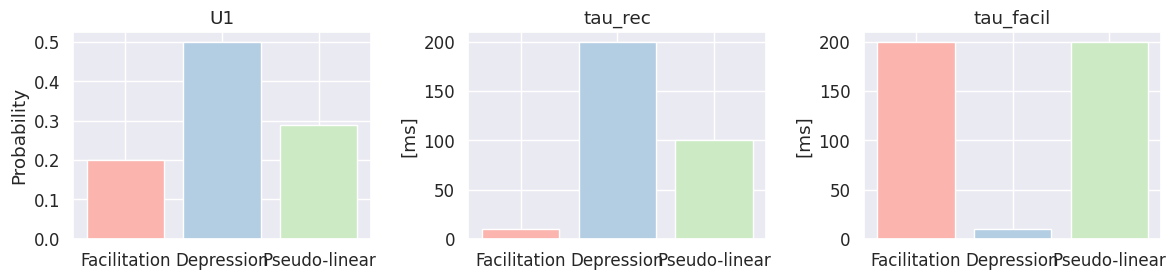

In [25]:
fig,ax = plt.subplots(1,3,figsize =(12,3))
name = ['Facilitation','Depression','Pseudo-linear']
color = plt.colormaps["Pastel1"](np.linspace(0,0.99/3,3))
U1 = [0.2,0.5,0.29]
tau_rec = [10,200,100]
tau_facil = [200,10,200]

ax[0].bar(name,U1,color = color)
ax[0].set_title('U1')
ax[0].set_ylabel('Probability')
ax[1].bar(name,tau_rec,color = color)
ax[1].set_title('tau_rec')
ax[1].set_ylabel('[ms]')
ax[2].bar(name,tau_facil,color = color)
ax[2].set_title('tau_facil')
ax[2].set_ylabel('[ms]')
plt.tight_layout()

U1 corresponds to the baseline release probability, i.e. fraction of synaptic resources used by a single AP. The greater this value is, the less available vesicles are left for further spikes.
tau_rec is an indicator of how long it takes for the synapse to completely recover and be as strong as before the first AP arrived. It usually is in the order of 100 ms;
tau_in is an indicator of how long it takes to inactivate the used resources; 

Synaptic depression is a phenomenon where the strength of a synaptic connection decreases with repeated or sustained synaptic activity. On the other hand, synaptic facilitation is a phenomenon where the strength of a synaptic connection increases with repeated or sustained synaptic activity. A pseudo-linear relation corresponds to a facilitation that becomes a depression as the neurons continue to be activated.  

Hence, we anticipate a gradual reduction in neurotransmitter release over time for synaptic depression. This is because when the initial utilization probability (U1) is high, a substantial proportion of vesicles is used during the first action potential, leaving fewer resources available for subsequent action potentials. Consequently, recovery takes longer, and the facilitation rate tends to be low, leading to weaker subsequent action potentials.

In contrast, facilitatory synapses typically exhibit a lower U1, which means that a smaller fraction of resources is consumed during the first spike, allowing a greater reserve for subsequent action potentials. Recovery from depression is rapid, and the facilitation rate is high, resulting in a strengthening of the spiking over time.

For synapses with a pseudolinear profile, resource utilization falls within a midrange, leaving enough vesicles for further activation but not as much as in facilitation. The recovery from depression is compensated by a relatively high facilitation recovery time, which means that while signals may weaken over time, it takes some time for them to become weaker and they persist at a diminished level for a considerable duration.

<span style="color:purple"> 
<font size='3'> 
    
## **Grading**: 
- [0.75 pt] for correct setup and plots of facilitating synapses plots
- [0.75 pt] for definition of the parameters, visualization and comparison 

[/1.5 pt]    
</span>

# <font color= 'red'>Ex 3:</font>  Compute EPSP's Features: amplitudes, latencies, tau rise and Coefficient of Variation (CV) of the EPSP amplitudes 

<font size='3'>Compute the amplitudes, latencies and tau rise of the excitatory postsynaptic potential (EPSP) of the three connections traces provided for your group (.h5 files you can find in the group folder). Visualize the mean values and standard deviations of this features.


<font size='3'>Then compute the coefficient of variation of EPSP amplitudes for each of the connections and the mean CV profile between them. Visualize your results in two plots:
- mean CV profiles: the plot should have four curves, one per each connection and one for the mean
- raster plot of CV of EPSP amplitudes as a function of EPSP amplitudes (all EPSPS, not only the first one)

<font size='3'>Both plots should look similar to the ones in the paper show in the lecture [Barros-Zulaica et al., 2019](https://www.ncbi.nlm.nih.gov/pubmed/31680928), Figure 1 D and F and Figure 6 D and F. 
    
<font size='3'>*Hint: Be careful with which plot should have a standard deviations!*
    
__Note that for all the files, the stimulation times are the same as in tutorial 3.__

<font size='3'><font color= 'red'>[2 pts]</font>

#### a) Getting the data from the .h5 files

In [26]:
# Open and print keys to check how many sweeps (repetitions) of the experiment there are in the file
data_c4 = h5py.File("Group8/connection_c4.h5", "r")
data_c60 = h5py.File("Group8/connection_c60.h5", "r")
data_c75 = h5py.File("Group8/connection_c75.h5", "r")
print(data_c4.keys())
print(data_c60.keys())
print(data_c75.keys())
c_types = ['c4', 'c60', 'c75']
datas = [data_c4, data_c60, data_c75]

<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>
<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>
<KeysViewHDF5 ['v0', 'v1', 'v10', 'v11', 'v12', 'v13', 'v14', 'v15', 'v16', 'v17', 'v18', 'v19', 'v2', 'v20', 'v21', 'v22', 'v23', 'v24', 'v25', 'v26', 'v27', 'v28', 'v29', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9']>


#### b) Plotting traces

In [27]:
def tracing(data):
    """Create a data array and compute the mean trace by computing the mean of all sweeps"""
    traces = []
    for key in data.keys():
        traces.append(data.get(key))

    traces = np.array(traces)

    mean_trace = np.mean(traces, axis=0)
    std_trace = np.std(traces, axis=0)
    return traces, mean_trace, std_trace

def plot_trace(ax, mean_trace, traces, std_trace, c_type):
    """plot the sweeps and the mean voltage trace"""
    
    for trace in traces:
        ax.plot(trace, "b--")

    ax.plot(mean_trace, "r")
    ax.fill_between(np.arange(len(mean_trace)), mean_trace - std_trace, mean_trace + std_trace, alpha=0.3, color ='r')
    ax.set_title(f"Sweep and Mean voltage trace of connection {c_type}")
    ax.set_ylabel('V (V)')
    ax.set_xlabel('time (ms)')

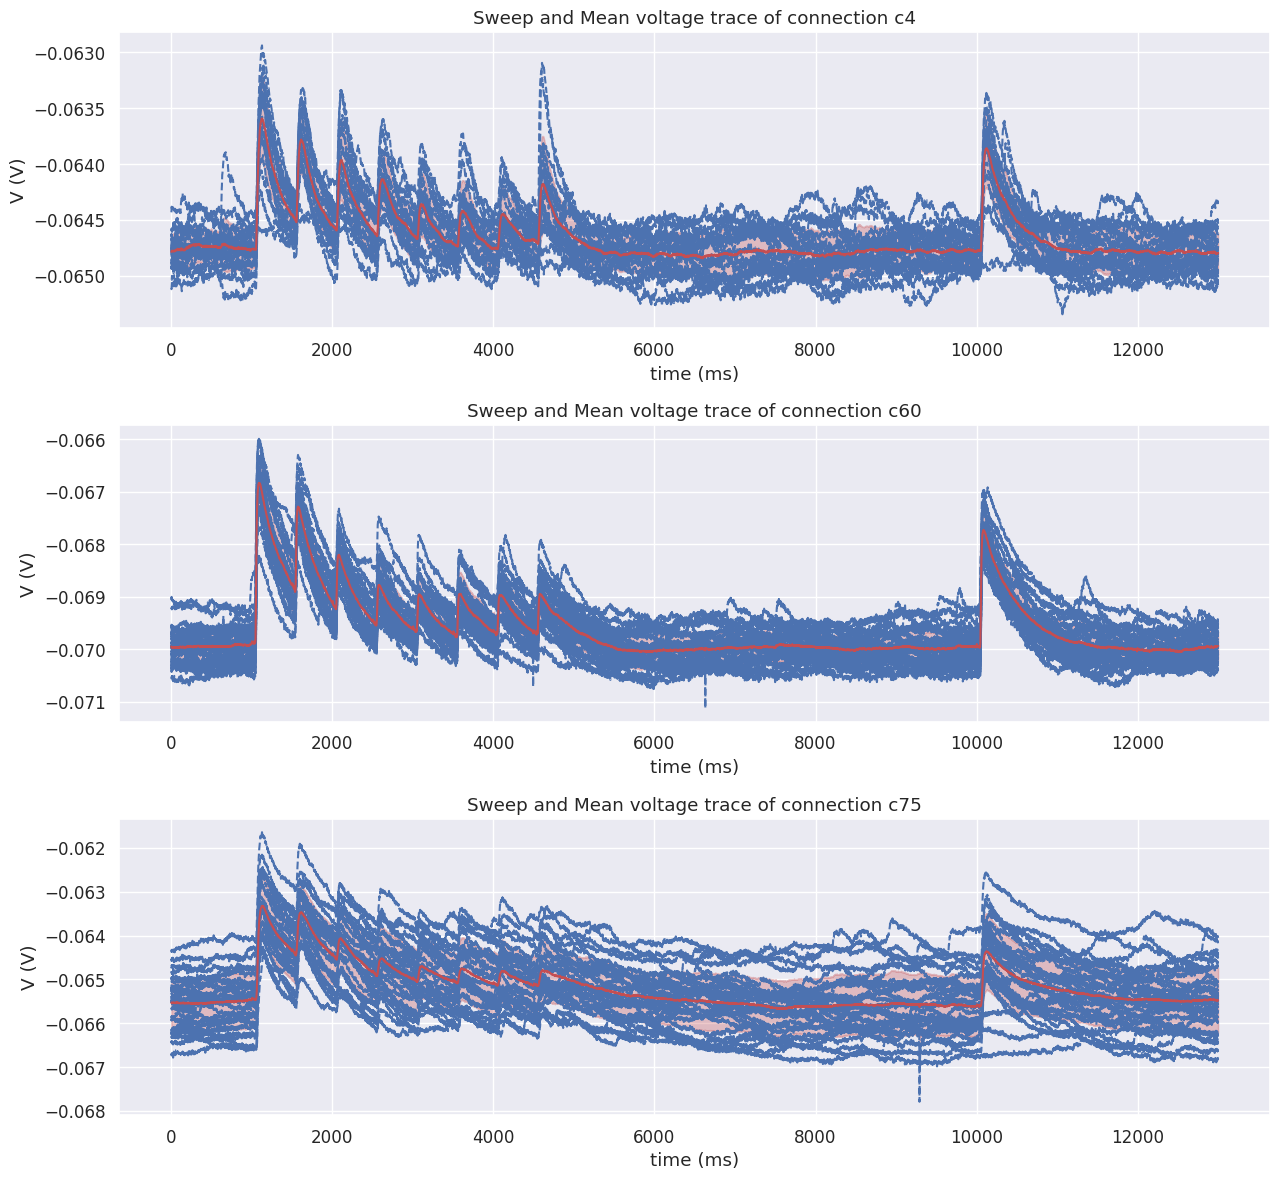

In [28]:
traces = []
mean_traces = []
std_traces = []
fig, axes = plt.subplots(3, 1, figsize=(13, 12))
axs = axes.flatten()
for data, c_type, ax in zip(datas, c_types, axs):
    trace, mean_trace, std_trace = tracing(data)
    traces.append(trace)
    mean_traces.append(mean_trace)
    std_traces.append(std_trace)
    plot_trace(ax, mean_trace, trace, std_trace, c_type)
plt.tight_layout()

#### c) Extracting features from first EPSP: tau rise, latency and amplitude

In [29]:
def extract_PSP_window(trace, time, stimulation_index, time_before=50, time_after=300):
    """Extract a time window with a single EPSP trace"""
    psp_trace = trace[stimulation_index - time_before : stimulation_index + time_after]
    psp_time = time[stimulation_index - time_before : stimulation_index + time_after]

    return psp_trace, psp_time

def extract_EPSP_features(psp_trace, psp_time, stimulation_time):
    """
    Function takes in a EPSP curve and calculates the following features: amplitude;
    5%, 20% and 80% of the amplitude, tau rise and latency. Based on defintions from
    Feldmeyer et al., 1999.

    Parameters
    ----------
    psp_trace : array with voltage trace [mV]
    psp_time : array of psp times [s]
    stimulation_time : time of the stimulation [s]

    Returns
    -------
    psp_percent : dictionary with psp amplitudes at 5%, 20% and 80% of the amplitude
    times : dictionary with psp times at 5%, 20% and 80% of the amplitude
    amplitude : amplitude of the first EPSP computed as the difference between the 20 and the 80 % of rise
    tau_rise : distance between the time of 20% and 80% of the rise of the EPSP [s]
    latency : time between the AP of the presynaptic cell and 5% amplitude rise of the EPSP [s]
    """

    # find absolute values of the psp trace
    max_psp = np.max(psp_trace)
    min_psp = np.min(psp_trace)
    amplitude_psp = np.abs(max_psp - min_psp)

    # compute percentages of amplitudes
    twenty_amplitude = amplitude_psp * 80.0 / 100.0
    eighty_amplitude = amplitude_psp * 20.0 / 100.0
    five_amplitude = amplitude_psp * 95.0 / 100.0
    amplitude = twenty_amplitude - eighty_amplitude

    # compute amplitude percentages on the psp trace
    psp_percent = {
        "five": -(five_amplitude - max_psp),
        "twenty": -(twenty_amplitude - max_psp),
        "eighty": -(eighty_amplitude - max_psp),
    }

    # find corresponding index of an array
    five_index = np.where(psp_trace >= psp_percent["five"])[0][0]
    twenty_index = np.where(psp_trace >= psp_percent["twenty"])[0][0]
    eighty_index = np.where(psp_trace >= psp_percent["eighty"])[0][0]

    # extract time points for percentage points of the trace
    psp_times = {
        "five": psp_time[five_index],
        "twenty": psp_time[twenty_index],
        "eighty": psp_time[eighty_index],
    }
    
    # calculate time features of a PSP
    tau_rise = np.abs((psp_times["twenty"] - psp_times["eighty"]))
    latency = np.abs((psp_times["five"]) - stimulation_time)

    return psp_percent, psp_times, abs(amplitude)*1000, tau_rise, latency

def extract_multi_EPSP_features(trace, time, stimulation_index):
    """Extracts all features for 1 trace of 1 connection type"""
    psp_traces = []
    psp_times = []
    amplitudes = []
    tau_rises = []
    latencies = []
    
    for index in stimulation_index:
        stimulation_time = time[index]
        psp_trace, psp_time = extract_PSP_window(trace, time, index)
        _, _, amplitude, tau_rise, latency = extract_EPSP_features(psp_trace, psp_time, stimulation_time)

        psp_traces.append(psp_trace)
        psp_times.append(psp_time)
        amplitudes.append(amplitude)
        tau_rises.append(tau_rise)
        latencies.append(latency)

    return psp_traces, psp_times, amplitudes, tau_rises, latencies

def multi_co_extraction(traces, time, stimulation_indices):
    """Extracts all features for all traces of 1 connection type"""
    amplitudes = []
    tau_rises = []
    latencies = []

    psp_traces = []
    psp_percents = []
    psp_times = []

    mean_latencies = []
    mean_amplitudes = []
    mean_tau_rises = []

    std_latencies = []
    std_amplitudes = []
    std_tau_rises = []

    for trace in traces:
        psp_trace, psp_time, amplitude, tau_rise, latency = extract_multi_EPSP_features(trace, time, stimulation_indices)
        # all means per trace
        mean_amplitude = np.mean(amplitude)
        mean_latency = np.mean(latency)
        mean_tau_rise = np.mean(tau_rise)
        
        # all stds per trace
        std_latency = np.std(latency)
        std_amplitude = np.std(amplitude)
        std_tau_rise = np.std(tau_rise)

        psp_traces.append(psp_trace)
        psp_times.append(psp_time)
        amplitudes.append(amplitude)
        tau_rises.append(tau_rise)
        latencies.append(latency)

        mean_amplitudes.append(mean_amplitude)
        mean_latencies.append(mean_latency)
        mean_tau_rises.append(mean_tau_rise)

        std_amplitudes.append(std_amplitude)
        std_latencies.append(std_latency)
        std_tau_rises.append(std_tau_rise)
    return psp_traces, psp_times, amplitudes, tau_rises, latencies, mean_amplitudes, mean_latencies, mean_tau_rises, std_amplitudes, std_latencies, std_tau_rises

def plot_feature(ax, mean, std, title, ylab, xlab, co_lab):
    """Plot mean and std of a feature"""""
    stim_lim = 9
    ax.plot(mean, label=co_lab)
    ax.fill_between(np.arange(len(mean)), np.array(mean) - np.array(std), np.array(mean) + np.array(std), alpha=0.2)
    ax.set_xlim(1, stim_lim)
    ax.set_title(title)
    ax.set_ylabel(ylab)
    ax.set_xticks(range(1, stim_lim + 1))
    ax.set_xticklabels(range(1, stim_lim + 1))
    ax.set_xlabel(xlab)
    

def add_all_connect_mean_std(all_mean, type="mean"):
    """Get mean and std of a features of all 3 connection type"""
    all_feat = all_mean.copy()
    df = pd.DataFrame(all_mean)
    if type == "mean":
        result = np.array(df.mean(axis=0, skipna=True))
    elif type == "std":
        result = np.array(df.std(axis=0, skipna=True))
    all_feat.append(result)
    return all_feat


##### Defining time array and stimulation protocol

In [30]:
time = np.linspace(0, 1.3, 13000)
stimulation_indices = np.array([1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 10000])

Calculating and plotting the mean and standard deviation of the EPSP amplitudes, latencies and tau rise for each connection type.

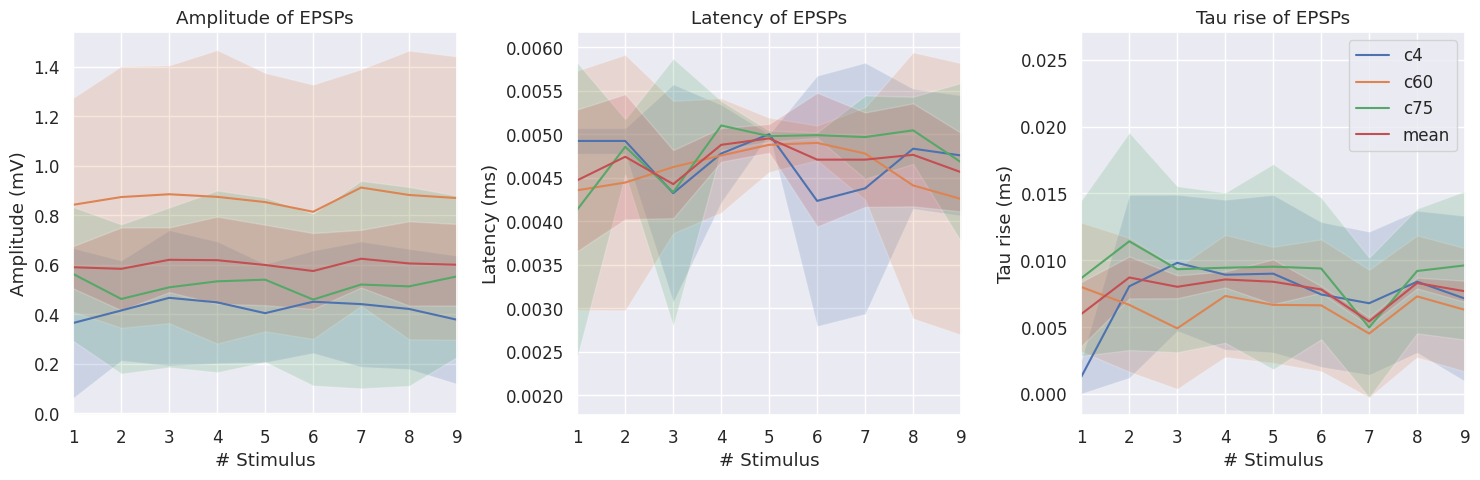

In [31]:
all_amplitudes = []
all_tau_rises = []
all_latencies = []

all_psp_traces = []
all_psp_percents = []
all_psp_times = []

all_mean_latencies = []
all_mean_amplitudes = []
all_mean_tau_rises = []

all_std_latencies = []
all_std_amplitudes = []
all_std_tau_rises = []

for trace in traces:
    psp_traces, psp_times, amplitudes, tau_rises, latencies, mean_amplitudes, mean_latencies, mean_tau_rises, std_amplitudes, std_latencies, std_tau_rises = multi_co_extraction(trace, time, stimulation_indices)
    all_amplitudes.append(amplitudes)
    all_tau_rises.append(tau_rises)
    all_latencies.append(latencies)
    all_psp_traces.append(psp_traces)
    all_psp_times.append(psp_times)

    all_mean_latencies.append(mean_latencies)
    all_mean_amplitudes.append(mean_amplitudes)
    all_mean_tau_rises.append(mean_tau_rises)

    all_std_latencies.append(std_latencies)
    all_std_amplitudes.append(std_amplitudes)
    all_std_tau_rises.append(std_tau_rises)

all_mean_amplitudes = add_all_connect_mean_std(all_mean_amplitudes, type="mean")
all_mean_latencies = add_all_connect_mean_std(all_mean_latencies, type="mean")
all_mean_tau_rises = add_all_connect_mean_std(all_mean_tau_rises, type="mean")

all_std_amplitudes = add_all_connect_mean_std(all_std_amplitudes, type="std")
all_std_latencies = add_all_connect_mean_std(all_std_latencies, type="std")
all_std_tau_rises = add_all_connect_mean_std(all_std_tau_rises, type="std")

connections = ['c4', 'c60', 'c75', 'mean']
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axs = axes.flatten()
for mean_amplitudes, std_amplitudes, mean_latencies, std_latencies, mean_tau_rises, std_tau_rises, co in zip(all_mean_amplitudes, all_std_amplitudes, all_mean_latencies, all_std_latencies, all_mean_tau_rises, all_std_tau_rises, connections):
    plot_feature(axs[0], mean_amplitudes, std_amplitudes, "Amplitude of EPSPs", "Amplitude (mV)", "# Stimulus", co)
    plot_feature(axs[1], mean_latencies, std_latencies, "Latency of EPSPs", "Latency (ms)", "# Stimulus", co)
    plot_feature(axs[2], mean_tau_rises, std_tau_rises, "Tau rise of EPSPs", "Tau rise (ms)", "# Stimulus", co)

plt.legend()
plt.tight_layout()





#### d) Computing CV of EPSP amplitudes
<font size='3'>Then compute the coefficient of variation of EPSP amplitudes for each of the connections and the mean CV profile between them. Visualize your results in two plots:
- mean CV profiles: the plot should have four curves, one per each connection and one for the mean
- raster plot of CV of EPSP amplitudes as a function of EPSP amplitudes (all EPSPS, not only the first one)

<font size='3'>Both plots should look similar to the ones in the paper show in the lecture [Barros-Zulaica et al., 2019](https://www.ncbi.nlm.nih.gov/pubmed/31680928), Figure 1 D and F and Figure 6 D and F. 
    
<font size='3'>*Hint: Be careful with which plot should have a standard deviations!*

In [32]:
# CV formula
def compute_CV(mean_amplitudes, std_amplitudes):
    """Compute CV of amplitudes"""
    return np.array(std_amplitudes) / np.array(mean_amplitudes)

Computing and ploting the the cv for each connection type and the mean cv profile between them.

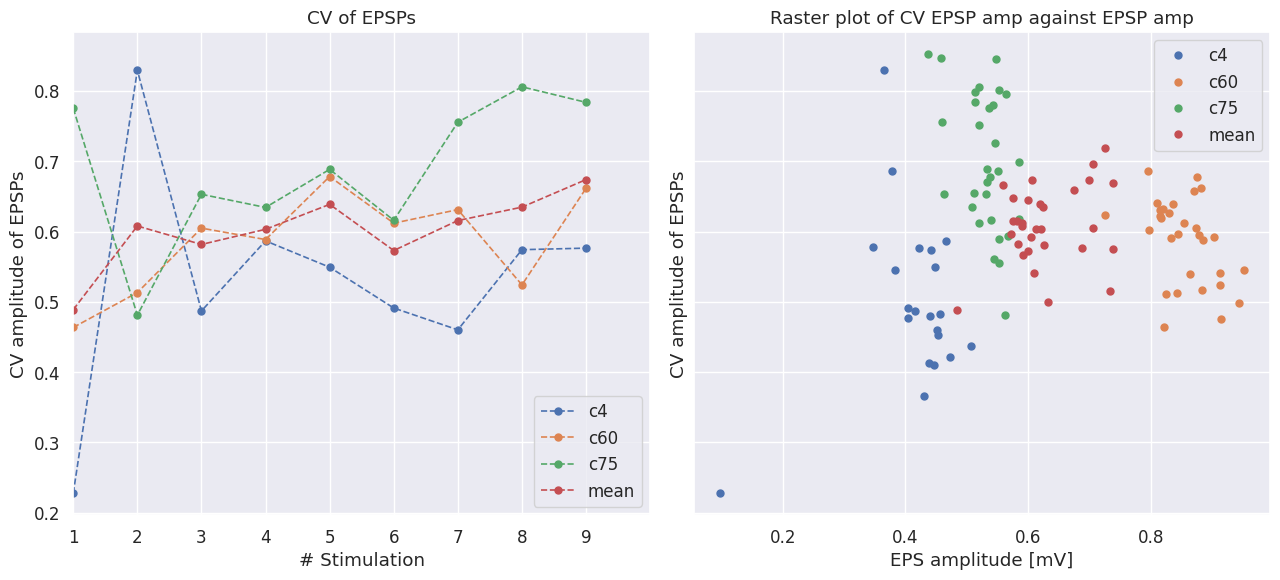

In [33]:
ind = 3
cvs= []
fig, axes = plt.subplots(1, 2, figsize=(13, 6), sharey=True)
plt.rcParams['lines.markersize'] = 10
plt.rcParams['lines.linewidth'] = 1.2
stim_lim = 9
for mean_amplitudes, std_amplitudes, co in zip(all_mean_amplitudes[0:ind], all_std_amplitudes[0:ind], connections[0:ind]):
    cv = compute_CV(mean_amplitudes, std_amplitudes)
    cvs.append(cv)
    axes[0].plot(cv[:stim_lim], '.--', label=co)
    axes[0].set_ylabel("CV amplitude of EPSPs")
    axes[0].set_xlabel("# Stimulation")
    axes[0].set_title("CV of EPSPs")
    axes[0].set_xlim(0, stim_lim)
    axes[0].set_xticks(range(stim_lim))
    axes[0].set_xticklabels(range(1, stim_lim+1))
    axes[0].legend()
    axes[1].plot(mean_amplitudes, cv, '.', label=co)
    axes[1].set_ylabel("CV amplitude of EPSPs")
    axes[1].set_xlabel("EPS amplitude [mV]")
    axes[1].set_title("Raster plot of CV EPSP amp against EPSP amp")
    axes[1].legend()
mean_cvs = add_all_connect_mean_std(cvs, type="mean")[-1]
axes[0].plot(mean_cvs[:stim_lim], '.--', label='mean')
axes[0].legend()
axes[1].plot(all_mean_amplitudes[-1], mean_cvs, '.', label='mean')
axes[1].legend()

plt.tight_layout()
plt.show()


<span style="color:purple"> 
<font size='3'> 
    
## **Grading**: 
- [0.75 pt] for correct CV calculation and visualization
- [0.75 pt] for extracting means and std of tau_rec and latency
- [0.5] for plotting CV of as a function of EPSPs amplitude    

[/2 pt]    
</span>

# <font color='red'>Ex 4:</font> Compute failure rate
<font size='3'>
    
Compute the failure rate of the EPSPs from the connections of your group folder. The failure rate is the fraction of trials from which no PSP is generated above certain threshold. You can find a way of computing the failure rate in [Feldmeyer et al., 1999](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2269646/) (Methods - Data analysis). Make sure to test for failure based on both latency and amplitude size. Necessary noise can be extracted from the initial part of the simulation, before any stimulus arrives (use the code bellow).


- Represent the mean result of each of the three connections in the same bar plot. 
- For each connection visualize the distributions of the EPSPs amplitudes using a histogram, with a different color for failed and successful EPSPs.

<font size='3'>
    
<font color= 'red'>[2 pts]</font>

In [34]:
# CODE TO EXTRACT NOISE FROM YOUR TRACES:

def compute_noise(trace, stimulation_index, time_before=50):
    pre_psp_trace = trace[0 : stimulation_index - time_before]
    noise_max = np.max(pre_psp_trace)
    noise_min = np.min(pre_psp_trace)
    noise_amp = np.abs(noise_max - noise_min)
    return noise_amp * 1000 
   


In [35]:
noise_collection = {}
noise_stds = {}
traces_collection = {i: traces[i] for i in range(len(traces))} # TO FIX -> to 21

for key, trs in traces_collection.items():
    noise = []
    for psp_trace in trs:
        noise.append(compute_noise(psp_trace, stimulation_indices[0]))
    noise_collection[key] = np.array(noise) 
    noise_stds[key] = np.std(np.array(noise))
    
     
noise_std = pd.Series(noise_stds)
noise_std


0    0.173947
1    0.093758
2    0.110848
dtype: float64

In [36]:
def compute_failure_rate(amplitudes, latencies, noise, mean_latency):
    """ Compute the failure rate for one trace"""
    
    failures = 0
    idx_failures = []
    for i, (amplitude, latency) in enumerate(zip(amplitudes, latencies)):
        if (amplitude < 1.5*noise) or (latency > 2.5*mean_latency):
            failures += 1
            idx_failures.append(i)
    
    failure_rate = failures / len(amplitudes)
    failed = ["failed" if idx in idx_failures else "not failed" for idx in range(len(amplitudes))]
    return failure_rate, failed
    

In [37]:
def compute_connection_failure_rate(amplitudes, latencies, noise, mean_latency):
    """Compute the average failure rate for one connection"""
    
    assert len(amplitudes) == len(latencies) 
    
    frs = []
    failed_frs = []
    for i in range(len(amplitudes)):
        fr, failed = compute_failure_rate(amplitudes[i], latencies[i], noise, mean_latency)
        frs.append(fr)
        failed_frs.append(failed)
        
    mean_FR = np.mean(np.array(fr))
    
    return mean_FR, failed_frs 
    

In [38]:
mean_FRs = []
failed_FS = []

for i in range(len(traces)):
    mean_FR, failed_f = compute_connection_failure_rate(all_amplitudes[i], all_latencies[i], noise_std[i], np.mean(np.array(all_mean_latencies[i])))
    mean_FRs.append(mean_FR)
    failed_FS.append(failed_f)

Text(0.5, 1.0, 'Mean failure rate across different connections')

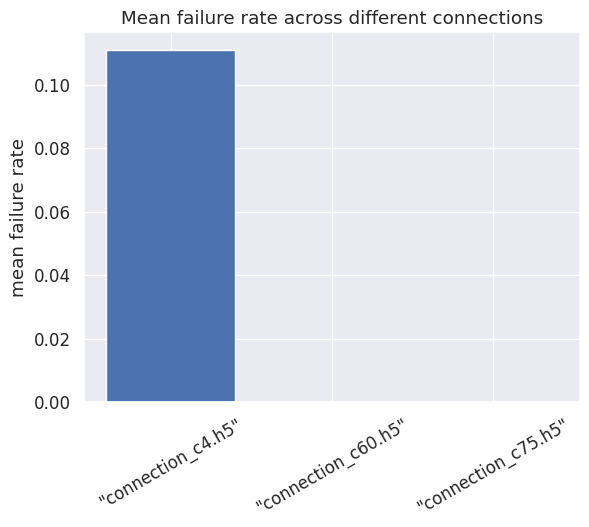

In [39]:
ax = plt.axes()
plt.bar(range(3), mean_FRs )
ax.set_xticks(range(3));
ax.set_xticklabels([str(d).split()[2] for d in datas], rotation = 30);
ax.set_ylabel('mean failure rate')
ax.set_title('Mean failure rate across different connections')

In [40]:
mean_FRs

[0.1111111111111111, 0.0, 0.0]

We notice that in the c4 connection the failure rate is on average 0.111. Instead, the others have mean failure rate equal to 0.0. This doesn't mean that none of the traces have failed EPSPs but that on average they don't. To observe more in detail the failures we plot now the distribution of EPSPs amplitudes for each connection. 

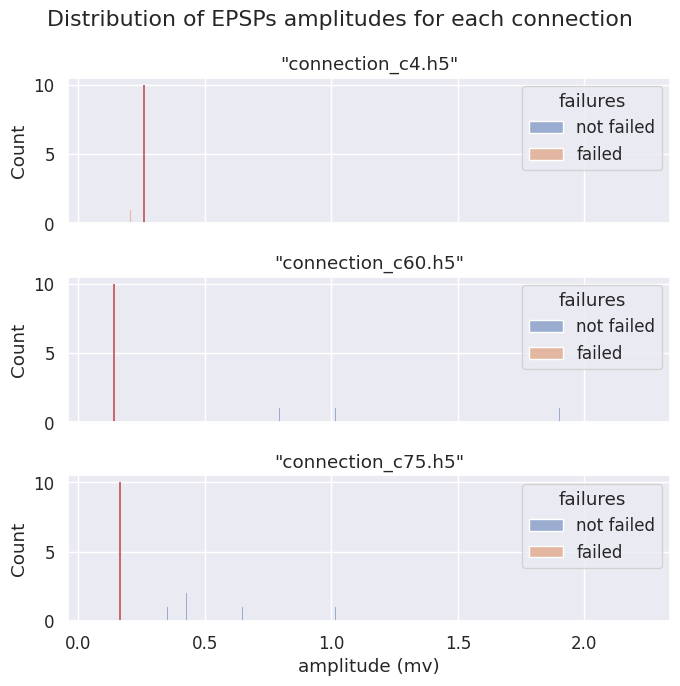

In [46]:
fig, axs = plt.subplots(3, 1, figsize=(7, 7), sharex=True, sharey=True)
axs_flat = axs.ravel()

for i in range(len(all_amplitudes)):
    pd_to_plot = pd.DataFrame({'amps': np.array(all_amplitudes[i]).ravel(), 'failures': np.array(failed_FS[i]).ravel()})
    sns.histplot(data=pd_to_plot, x="amps", hue="failures", ax=axs_flat[i], hue_order = ['not failed', 'failed'], binwidth=0.00007)
    axs_flat[i].vlines(1.5 * noise_std[i], 0, 10, 'r', label='noise')
    
    axs_flat[i].set_title([str(d).split()[2] for d in datas][i])
plt.xlabel("amplitude (mv)");
fig.suptitle("Distribution of EPSPs amplitudes for each connection")
plt.tight_layout()

Here, in the red line we plot the noise standard deviation multiplied by 1.5 (noise threshold). We notice that there also in connection c75 there are some failures; instead there are no failures in connection c60. Note that overlapping bins (i.e., orange and blue in connection c4) are due to the binning size.  
We've noticed that failures primarily stem from noise rather than the mean latency (at least if there is failure due to the mean latency threshold it is also caused by the noise one). This is evident as all failures consistently occur to the left of the noise threshold.

<span style="color:purple"> 
<font size='3'> 
    
## **Grading**: 
- [1 pt] for calculating failure rate
- [0.5 pt] for bar plots visualization 
- [0.5 pt] for EPSPs amplitudes histograms with failure/success split

[/2 pt]    
</span>